In [2]:
import numpy as np                 #for general calculations.
import matplotlib.pyplot as plt    #making plots.
import xarray as xr                #loading and working with data in an optimal way.
import pandas as pd

from matplotlib.animation import FuncAnimation  #creating animations and videos.
from IPython.display import Video, HTML         #embedding videos in the notebook

import cartopy.crs as ccrs         # to plot maps with different projections
import cartopy.feature as cfeature # to plot coastlines, land, borders, etc.

In [2]:
!pip install xarray[complete]
!pip install s3fs
!pip install zarr

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   --------------------------- ------------ 6.6/9.7 MB 36.6 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.7 MB 36.7 MB/s eta 0:00:01
   ---------------------------------------- 9.7/9.7 MB 18.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 8.7/8.7 MB 41.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/829.7 kB ? eta -:--:--
   --------------------------------------- 829.7/829.7 kB 35.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ----------------- ---------------------- 10.7/25.1 MB 55.8 MB/s eta 0:00:01
   --------------------------------- ------ 21.0/25.1 MB 53.0 MB/s eta 0:00:01
   ---------------------------------------  24.9/25.1 MB 49.3 MB/s eta 0:

In [3]:
spotter_data='spotter_data_bulk.nc'    #loading from local path

spotter = xr.open_dataset(spotter_data)  #xarray can open different format data, netcdf is one of them

spotter = spotter.drop_vars(["peakPeriod", "meanPeriod", "peakDirection", "peakDirectionalSpread", "meanDirection", "meanDirectionalSpread", "rowsize"])

#spotter = spotter.drop_dims("index")

spotter = spotter.sortby('time')
spotter = spotter.isel(index=slice(4885158, 5536373))
spotter

<xarray.Dataset> Size: 21MB
Dimensions:                (index: 651215, trajectory: 871)
Coordinates:
    time                   (index) datetime64[ns] 5MB ...
  * trajectory             (trajectory) <U12 42kB 'SPOT-010001' ... 'SPOT-1975'
Dimensions without coordinates: index
Data variables:
    significantWaveHeight  (index) float64 5MB ...
    latitude               (index) float64 5MB ...
    longitude              (index) float64 5MB ...
Attributes:
    title:          Sofar Spotter Data Archive - Bulk Wave Parameters
    institution:    Sofar Ocean
    source:         Spotter wave buoy
    creation_date:  2023-10-18 00:43:55.333537
    author:         Isabel A. Houghton
    email:          isabel.houghton@sofarocean.com
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...

In [99]:
# FOR FINDING INDICES FOR TIMES NOV 2021 THRU DEC 2021
np.where(spotter.time.sortby("time") <=np.datetime64("2022-01-01"))

(array([      0,       1,       2, ..., 5536371, 5536372, 5536373]),)

In [91]:
all_indices = np.where((spotter.time>=np.datetime64("2021-11-01")) & (spotter.time<=np.datetime64("2021-12-31")))[0]

#spotter["significantWaveHeight"] = spotter.significantWaveHeight[all_indices]
#spotter["longitude"] = spotter.longitude[all_indices]
#spotter["latitude"] = spotter.latitude[all_indices]
#spotter["time"] = spotter.time[all_indices]

all_indices.size


639847

In [4]:
wind_data='era5_winds_nov_dec_21.nc'    #loading from local path

wind = xr.open_dataset(wind_data)  #xarray can open different format data, netcdf is one of them

wind['longitude'] = ((wind.longitude - 180) % 360) - 180
wind['longitude'] = wind['longitude'].sortby('longitude')

wind

<xarray.Dataset> Size: 24GB
Dimensions:    (longitude: 1440, latitude: 721, time: 1464)
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 12kB 2021-11-01 ... 2021-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float64 12GB ...
    v10        (time, latitude, longitude) float64 12GB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-19 22:20:15 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [21]:
N = 100
wind.u10[::N]


#print('The number of values that are NOT nan:', np.count_nonzero(~np.isnan(wind.v10.isel(time=0).sortby('longitude'))))
#print('The size of this array:', wind.v10.isel(time=0).sortby('longitude').size)

<xarray.DataArray 'u10' (time: 15, latitude: 721, longitude: 1440)> Size: 125MB
[15573600 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 120B 2021-11-01 ... 2021-12-29T08:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

In [6]:
spotter = spotter.set_coords(("latitude", "longitude", "time"))
spotter.latitude

<xarray.DataArray 'latitude' (index: 651215)> Size: 5MB
[651215 values with dtype=float64]
Coordinates:
    time       (index) datetime64[ns] 5MB ...
    latitude   (index) float64 5MB ...
    longitude  (index) float64 5MB ...
Dimensions without coordinates: index
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north

In [54]:
spotter["u10_era5_FULL"] = wind.u10.interp(time=spotter.time, latitude=spotter.latitude, longitude=spotter.longitude, method="linear")
spotter["v10_era5_FULL"] = wind.v10.interp(time=spotter.time, latitude=spotter.latitude, longitude=spotter.longitude, method="linear")

In [55]:
spotter

<xarray.Dataset> Size: 42MB
Dimensions:                (index: 651215, trajectory: 871)
Coordinates:
    time                   (index) datetime64[ns] 5MB 2021-11-01T00:00:49 ......
    latitude               (index) float64 5MB -24.02 33.24 ... 28.18 39.65
    longitude              (index) float64 5MB 85.95 -41.37 ... -36.55 -177.0
  * trajectory             (trajectory) <U12 42kB 'SPOT-010001' ... 'SPOT-1975'
Dimensions without coordinates: index
Data variables:
    significantWaveHeight  (index) float64 5MB 2.623 2.883 0.463 ... 3.336 4.589
    u10_era5               (index) float64 5MB -2.457 -1.915 1.586 ... nan nan
    v10_era5               (index) float64 5MB 2.01 -0.6218 -0.1799 ... nan nan
    u10_era5_FULL          (index) float64 5MB -2.458 -1.921 1.583 ... nan nan
    v10_era5_FULL          (index) float64 5MB 2.012 -0.6237 -0.1748 ... nan nan
Attributes:
    title:          Sofar Spotter Data Archive - Bulk Wave Parameters
    institution:    Sofar Ocean
    source:         Spotter wave buoy
    creation_date:  2023-10-18 00:43:55.333537
    author:         Isabel A. Houghton
    email:          isabel.houghton@sofarocean.com
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...

In [35]:
spotter.u10_era5.size

651215

In [31]:
spotter.u10_era5.data

np.count_nonzero(~np.isnan(spotter.u10_era5.data))

620395

In [32]:
# Assuming dss is your dataset and has a 'time' dimension.
# Create the 'testing' dataset with wave height, u10_era5, and v10_era5 data
testing = xr.Dataset(
    data_vars=dict(
        wave_height=(['time'], spotter.significantWaveHeight.data),
        u10_era5=(['time'], spotter.u10_era5_FULL.data),  # Add u10_era5 data
        v10_era5=(['time'], spotter.v10_era5_FULL.data)   # Add v10_era5 data
    ),
    coords=dict(
        lat=('time', spotter.latitude.data),
        lon=('time', spotter.longitude.data),
        time=('time', spotter.time.data)
    ),
    attrs=dict(spotter.attrs)
)

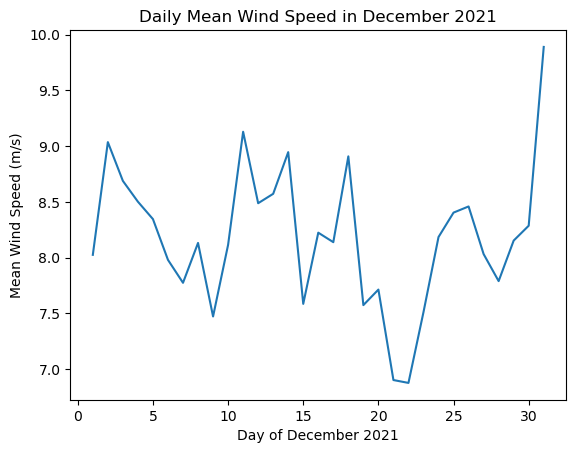

In [12]:
# Sort the dataset by the 'time' index to ensure it's monotonic
testing = testing.sortby('time')

# Calculate wind speed from the u10 and v10 components
testing["wind_speed"] = np.sqrt(testing["u10_era5"]**2 + testing["v10_era5"]**2)

# Set 'time' as index (if not already set)
testing = testing.set_index(time='time')

# Filter data for December 2021
december_data = testing.sel(time=slice('2021-12-01', '2021-12-31'))

# Calculate daily mean wind speed, grouping by day
daily_mean_wind_speed = december_data.wind_speed.groupby('time.day').mean()

# Plot the results
plt.plot(daily_mean_wind_speed['day'], daily_mean_wind_speed)
plt.xlabel('Day of December 2021')
plt.ylabel('Mean Wind Speed (m/s)')
plt.title('Daily Mean Wind Speed in December 2021')
plt.show()

In [26]:
# THIS IS HOW YOU GET WIND DATA ON A DAY BY DAY BASIS

testing.sel(time=slice('2021-12-01', '2021-12-31'))["u10_era5"].groupby('time.day').mean()

<xarray.DataArray 'u10_era5' (day: 31)> Size: 248B
array([-0.15981271, -0.08653638, -0.03931704,  0.03558466,  0.08494248,
        0.04282686,  0.06350547,  0.1212889 ,  0.26723827,  0.38919747,
        0.52549334,  0.62071589,  0.66278588,  0.63413043,  0.60014733,
        0.53513209,  0.58149234,  0.67170032,  0.78992077,  0.86954375,
        0.85791062,  0.76812968,  0.68890944,  0.60075274,  0.61645419,
        0.79693103,  0.9931895 ,  1.23054966,  1.45707753,         nan,
               nan])
Coordinates:
  * day      (day) int64 248B 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31

In [29]:
testing["wind_speed"] = np.sqrt(testing["u10_era5"]**2 + testing["v10_era5"]**2)

testing = testing.set_index(time='time')

december_data = testing.sel(time=slice('2021-12-01', '2021-12-31'))
december_data
daily_mean_wind_speed = december_data.wind_speed.groupby('time.day').mean()
daily_mean_wind_speed

<xarray.DataArray 'wind_speed' (day: 31)> Size: 248B
array([8.02503189, 9.03563666, 8.68794624, 8.5014492 , 8.34539415,
       7.9799003 , 7.77431717, 8.13186922, 7.47244104, 8.11483967,
       9.12876181, 8.48793731, 8.57223572, 8.94595229, 7.58561793,
       8.22374804, 8.13862395, 8.90796659, 7.57428247, 7.71357815,
       6.90254593, 6.87673614, 7.51166532, 8.18481098, 8.40376536,
       8.45888649, 8.03202992, 7.78955297, 8.1528651 , 8.28620895,
       9.88921354])
Coordinates:
  * day      (day) int64 248B 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31

# DO NOT TOUCH. THIS IS A WORKING MAP.

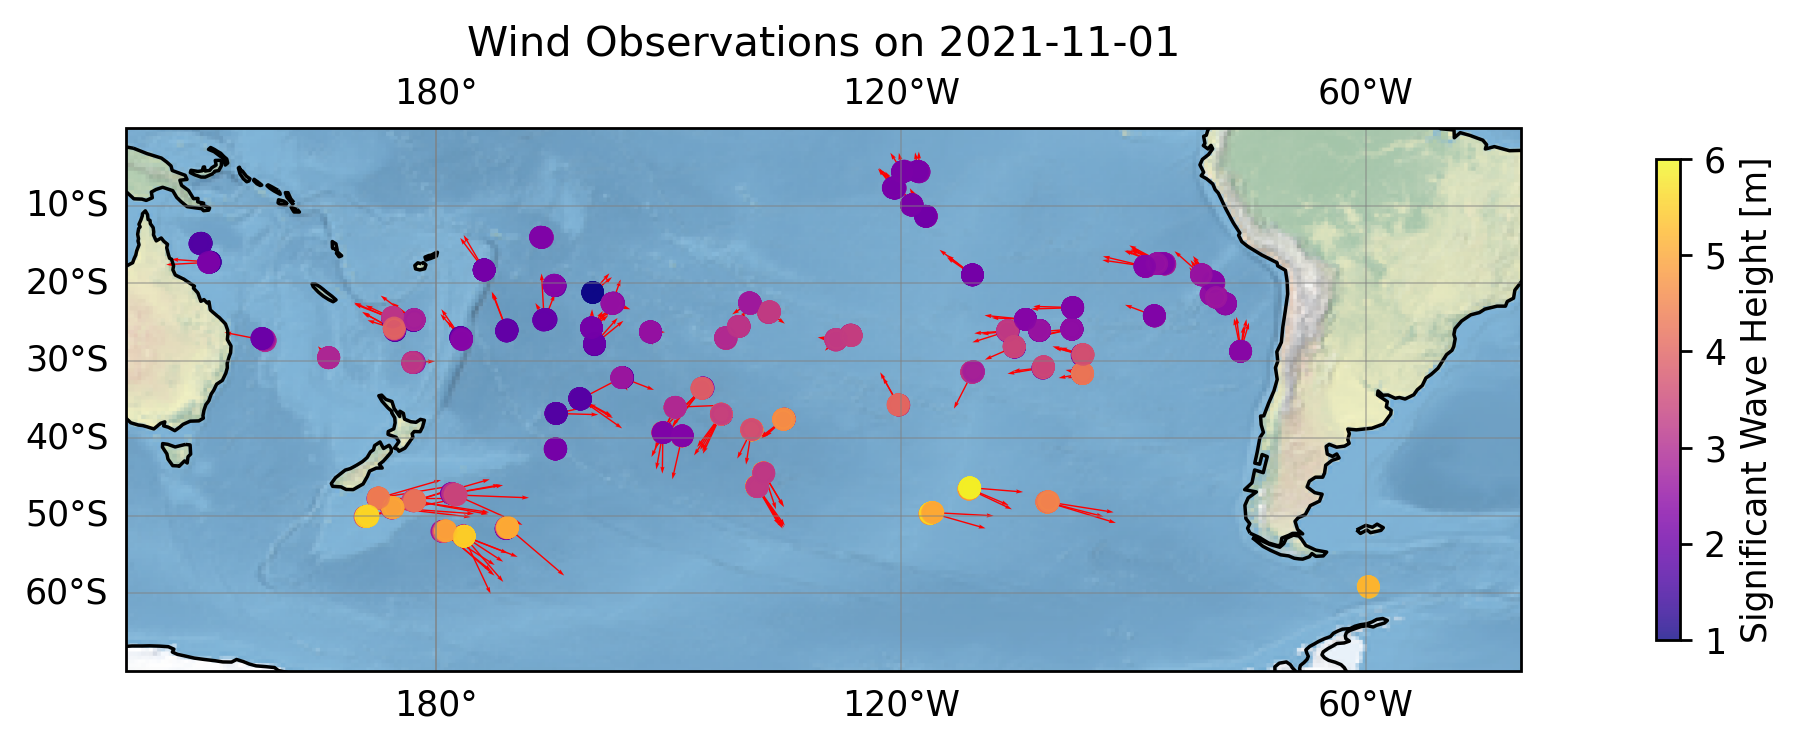

In [157]:
# set plotting parameters (min, max for colors and map projection)
h_min = 1
h_max = 6

proj = ccrs.PlateCarree(central_longitude=230)

time = '2021-11-01'
time_string = '2021-11-01T00:00'

target_time_start = np.datetime64(time_string)
target_time_end = np.datetime64(time_string) + np.timedelta64(1,'D')
    
# find all data points at time of interest
all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

# set up cartopy map
fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=.5, color='gray', alpha=0.5)

ax.set_extent([140, 320, -70, 0], crs=ccrs.PlateCarree())

N = 10
windlat = testing.sel(time=time).lat.data
windlon = testing.sel(time=time).lon.data
u = testing.sel(time=time).u10_era5.data
v = testing.sel(time=time).v10_era5.data

# Lat_Seattle=47.6062; Lon_Seattle=-122.3321  # Seattle coordinate

ax.stock_img()

ax.quiver(windlon[::N], windlat[::N], u[::N], v[::N],
          transform=ccrs.PlateCarree(),
          width=0.001, 
          scale=300,
          color='red')

pcm1 = ax.scatter(spotter.longitude[all_indices], 
            spotter.latitude[all_indices],
            c=spotter.significantWaveHeight[all_indices],
            s=30,
            cmap='plasma', #Spectral_r
            alpha=0.8,
            vmin=h_min, vmax=h_max,
            transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5, anchor=(0.2,0.5))

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(f'Wind Observations on 2021-11-01')
plt.show()

# CORRECT GIF CODE
# DO NOT TOUCH: COPY IF YOU WANT TO EDIT

In [135]:
def waveframedata(i):
    target_time_start = np.datetime64(time_string) + np.timedelta64(i,'D')
    target_time_end = np.datetime64(time_string) + np.timedelta64(i+1,'D')
    
    # find all data points at time of interest
    all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

    return spotter.longitude[all_indices], spotter.latitude[all_indices], spotter.significantWaveHeight[all_indices]

def windframedata(i):
    windtime = np.datetime64(time) + np.timedelta64(i,'D')
    windlon = testing.sel(time=str(windtime)).lon.data
    windlat = testing.sel(time=str(windtime)).lat.data
    u = testing.sel(time=str(windtime)).u10_era5.data
    v = testing.sel(time=str(windtime)).v10_era5.data

    return windlon, windlat, u, v


def update(i):
    ax.clear()

    # set up cartopy map
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=.5, color='gray', alpha=0.5)

    ax.set_extent([120, 290, -70, 70], crs=ccrs.PlateCarree())

    ax.stock_img()

    transparencyinterval = 0.05 # change transparencyinterval to determine length of the buoy trajectory

    N = 10
    ax.quiver(windframedata(i)[0][::N], windframedata(i)[1][::N], windframedata(i)[2][::N], windframedata(i)[3][::N],
            transform=ccrs.PlateCarree(),
            width=0.001, 
            scale=300,
            color='red')

    for j in np.arange(0,i):
        ax.scatter(waveframedata(i-j)[0], 
                waveframedata(i-j)[1],
                c=waveframedata(i-j)[2],
                s=30,
                cmap='plasma', #Spectral_r
                alpha=max(0, 1 - transparencyinterval*j),
                vmin=h_min, vmax=h_max,
                zorder= 100-j, # ensures more recent points show up on top
                transform=ccrs.PlateCarree())
    
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(f'H$_s$ and Wind Observations on {np.datetime64(time_string) + np.timedelta64(i,'D')}')

fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)

# set plotting parameters (min, max for colors and map projection)
h_min = 1
h_max = 6
N = 100

proj = ccrs.PlateCarree(central_longitude=180)

time = '2021-11-01'
time_string = '2021-11-01T00:00'

target_time_start = np.datetime64(time_string)
target_time_end = np.datetime64(time_string) + np.timedelta64(1,'D')

all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

pcm1 = ax.scatter(spotter.longitude[all_indices], 
                      spotter.latitude[all_indices],
                      c=spotter.significantWaveHeight[all_indices],
                      s=30,
                      cmap='plasma',
                      alpha=1,
                      vmin=h_min, vmax=h_max,
                     transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5)

spotteranimation = FuncAnimation(fig, update, 
                          frames = 61)

spotteranimation.save('spotter_novdec2021fade_windy.gif', fps=10) 
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


# NORTH ATLANTIC OCEAN

In [143]:
def waveframedata(i):
    target_time_start = np.datetime64(time_string) + np.timedelta64(i,'D')
    target_time_end = np.datetime64(time_string) + np.timedelta64(i+1,'D')
    
    # find all data points at time of interest
    all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

    return spotter.longitude[all_indices], spotter.latitude[all_indices], spotter.significantWaveHeight[all_indices]

def windframedata(i):
    windtime = np.datetime64(time) + np.timedelta64(i,'D')
    windlon = testing.sel(time=str(windtime)).lon.data
    windlat = testing.sel(time=str(windtime)).lat.data
    u = testing.sel(time=str(windtime)).u10_era5.data
    v = testing.sel(time=str(windtime)).v10_era5.data

    return windlon, windlat, u, v


def update(i):
    ax.clear()

    # set up cartopy map
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=.5, color='gray', alpha=0.5)

    ax.set_extent([-100, 0, 0, 70], crs=ccrs.PlateCarree())

    ax.stock_img()

    transparencyinterval = 0.1 # change transparencyinterval to determine length of the buoy trajectory

    N = 10
    ax.quiver(windframedata(i)[0][::N], windframedata(i)[1][::N], windframedata(i)[2][::N], windframedata(i)[3][::N],
            transform=ccrs.PlateCarree(),
            width=0.001, 
            scale=300,
            color='red')

    for j in np.arange(0,i):
        ax.scatter(waveframedata(i-j)[0], 
                waveframedata(i-j)[1],
                c=waveframedata(i-j)[2],
                s=30,
                cmap='plasma', #Spectral_r
                alpha=max(0, 1 - transparencyinterval*j),
                vmin=h_min, vmax=h_max,
                zorder= 100-j, # ensures more recent points show up on top
                transform=ccrs.PlateCarree())
    
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(f'H$_s$ and Wind Observations on {np.datetime64(time_string) + np.timedelta64(i,'D')}')

# set plotting parameters (min, max for colors and map projection)
h_min = 1
h_max = 6
N = 100

proj = ccrs.PlateCarree(central_longitude=-50)

fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)

time = '2021-11-01'
time_string = '2021-11-01T00:00'

target_time_start = np.datetime64(time_string)
target_time_end = np.datetime64(time_string) + np.timedelta64(1,'D')

all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

pcm1 = ax.scatter(spotter.longitude[all_indices], 
                      spotter.latitude[all_indices],
                      c=spotter.significantWaveHeight[all_indices],
                      s=30,
                      cmap='plasma',
                      alpha=1,
                      vmin=h_min, vmax=h_max,
                     transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5, anchor=(0.2,0.5))

spotteranimation = FuncAnimation(fig, update, 
                          frames = 61)

spotteranimation.save('spotter_novdec2021fade_windy_northatlantic.gif', fps=10) 
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


# SOUTH ATLANTIC OCEAN

In [141]:
def waveframedata(i):
    target_time_start = np.datetime64(time_string) + np.timedelta64(i,'D')
    target_time_end = np.datetime64(time_string) + np.timedelta64(i+1,'D')
    
    # find all data points at time of interest
    all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

    return spotter.longitude[all_indices], spotter.latitude[all_indices], spotter.significantWaveHeight[all_indices]

def windframedata(i):
    windtime = np.datetime64(time) + np.timedelta64(i,'D')
    windlon = testing.sel(time=str(windtime)).lon.data
    windlat = testing.sel(time=str(windtime)).lat.data
    u = testing.sel(time=str(windtime)).u10_era5.data
    v = testing.sel(time=str(windtime)).v10_era5.data

    return windlon, windlat, u, v


def update(i):
    ax.clear()

    # set up cartopy map
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=.5, color='gray', alpha=0.5)

    ax.set_extent([-75, 25, -70, 0], crs=ccrs.PlateCarree())

    ax.stock_img()

    transparencyinterval = 0.2 # change transparencyinterval to determine length of the buoy trajectory

    N = 10
    ax.quiver(windframedata(i)[0][::N], windframedata(i)[1][::N], windframedata(i)[2][::N], windframedata(i)[3][::N],
            transform=ccrs.PlateCarree(),
            width=0.001, 
            scale=300,
            color='red')

    for j in np.arange(0,i):
        ax.scatter(waveframedata(i-j)[0], 
                waveframedata(i-j)[1],
                c=waveframedata(i-j)[2],
                s=30,
                cmap='plasma', #Spectral_r
                alpha=max(0, 1 - transparencyinterval*j),
                vmin=h_min, vmax=h_max,
                zorder= 100-j, # ensures more recent points show up on top
                transform=ccrs.PlateCarree())
    
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(f'H$_s$ and Wind Observations on {np.datetime64(time_string) + np.timedelta64(i,'D')}')

# set plotting parameters (min, max for colors and map projection)
h_min = 1
h_max = 6
N = 100

proj = ccrs.PlateCarree(central_longitude=-50)

fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)

time = '2021-11-01'
time_string = '2021-11-01T00:00'

target_time_start = np.datetime64(time_string)
target_time_end = np.datetime64(time_string) + np.timedelta64(1,'D')

all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

pcm1 = ax.scatter(spotter.longitude[all_indices], 
                      spotter.latitude[all_indices],
                      c=spotter.significantWaveHeight[all_indices],
                      s=30,
                      cmap='plasma',
                      alpha=1,
                      vmin=h_min, vmax=h_max,
                     transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5, anchor=(0.2,0.5))

spotteranimation = FuncAnimation(fig, update, 
                          frames = 61)

spotteranimation.save('spotter_novdec2021fade_windy_southatlantic.gif', fps=10) 
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


# INDIAN OCEAN

In [149]:
def waveframedata(i):
    target_time_start = np.datetime64(time_string) + np.timedelta64(i,'D')
    target_time_end = np.datetime64(time_string) + np.timedelta64(i+1,'D')
    
    # find all data points at time of interest
    all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

    return spotter.longitude[all_indices], spotter.latitude[all_indices], spotter.significantWaveHeight[all_indices]

def windframedata(i):
    windtime = np.datetime64(time) + np.timedelta64(i,'D')
    windlon = testing.sel(time=str(windtime)).lon.data
    windlat = testing.sel(time=str(windtime)).lat.data
    u = testing.sel(time=str(windtime)).u10_era5.data
    v = testing.sel(time=str(windtime)).v10_era5.data

    return windlon, windlat, u, v


def update(i):
    ax.clear()

    # set up cartopy map
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=.5, color='gray', alpha=0.5)

    ax.set_extent([20, 160, -70, 25], crs=ccrs.PlateCarree())

    ax.stock_img()

    transparencyinterval = 0.2 # change transparencyinterval to determine length of the buoy trajectory

    N = 10
    ax.quiver(windframedata(i)[0][::N], windframedata(i)[1][::N], windframedata(i)[2][::N], windframedata(i)[3][::N],
            transform=ccrs.PlateCarree(),
            width=0.001, 
            scale=300,
            color='red')

    for j in np.arange(0,i):
        ax.scatter(waveframedata(i-j)[0], 
                waveframedata(i-j)[1],
                c=waveframedata(i-j)[2],
                s=30,
                cmap='plasma', #Spectral_r
                alpha=max(0, 1 - transparencyinterval*j),
                vmin=h_min, vmax=h_max,
                zorder= 100-j, # ensures more recent points show up on top
                transform=ccrs.PlateCarree())
    
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(f'H$_s$ and Wind Observations on {np.datetime64(time_string) + np.timedelta64(i,'D')}')

# set plotting parameters (min, max for colors and map projection)
h_min = 1
h_max = 6
N = 100

proj = ccrs.PlateCarree(central_longitude=95)

fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)

time = '2021-11-01'
time_string = '2021-11-01T00:00'

target_time_start = np.datetime64(time_string)
target_time_end = np.datetime64(time_string) + np.timedelta64(1,'D')

all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

pcm1 = ax.scatter(spotter.longitude[all_indices], 
                      spotter.latitude[all_indices],
                      c=spotter.significantWaveHeight[all_indices],
                      s=30,
                      cmap='plasma',
                      alpha=1,
                      vmin=h_min, vmax=h_max,
                     transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5, anchor=(0.2,0.5))

spotteranimation = FuncAnimation(fig, update, 
                          frames = 61)

spotteranimation.save('spotter_novdec2021fade_windy_indian.gif', fps=10) 
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


# NORTH PACIFIC OCEAN

In [155]:
def waveframedata(i):
    target_time_start = np.datetime64(time_string) + np.timedelta64(i,'D')
    target_time_end = np.datetime64(time_string) + np.timedelta64(i+1,'D')
    
    # find all data points at time of interest
    all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

    return spotter.longitude[all_indices], spotter.latitude[all_indices], spotter.significantWaveHeight[all_indices]

def windframedata(i):
    windtime = np.datetime64(time) + np.timedelta64(i,'D')
    windlon = testing.sel(time=str(windtime)).lon.data
    windlat = testing.sel(time=str(windtime)).lat.data
    u = testing.sel(time=str(windtime)).u10_era5.data
    v = testing.sel(time=str(windtime)).v10_era5.data

    return windlon, windlat, u, v


def update(i):
    ax.clear()

    # set up cartopy map
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=.5, color='gray', alpha=0.5)

    ax.set_extent([120, 280, 0, 70], crs=ccrs.PlateCarree())

    ax.stock_img()

    transparencyinterval = 0.2 # change transparencyinterval to determine length of the buoy trajectory

    N = 10
    ax.quiver(windframedata(i)[0][::N], windframedata(i)[1][::N], windframedata(i)[2][::N], windframedata(i)[3][::N],
            transform=ccrs.PlateCarree(),
            width=0.001, 
            scale=300,
            color='red')

    for j in np.arange(0,i):
        ax.scatter(waveframedata(i-j)[0], 
                waveframedata(i-j)[1],
                c=waveframedata(i-j)[2],
                s=30,
                cmap='plasma', #Spectral_r
                alpha=max(0, 1 - transparencyinterval*j),
                vmin=h_min, vmax=h_max,
                zorder= 100-j, # ensures more recent points show up on top
                transform=ccrs.PlateCarree())
    
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(f'H$_s$ and Wind Observations on {np.datetime64(time_string) + np.timedelta64(i,'D')}')

# set plotting parameters (min, max for colors and map projection)
h_min = 1
h_max = 6
N = 100

proj = ccrs.PlateCarree(central_longitude=200)

fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)

time = '2021-11-01'
time_string = '2021-11-01T00:00'

target_time_start = np.datetime64(time_string)
target_time_end = np.datetime64(time_string) + np.timedelta64(1,'D')

all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

pcm1 = ax.scatter(spotter.longitude[all_indices], 
                      spotter.latitude[all_indices],
                      c=spotter.significantWaveHeight[all_indices],
                      s=30,
                      cmap='plasma',
                      alpha=1,
                      vmin=h_min, vmax=h_max,
                     transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5, anchor=(0.2,0.5))

spotteranimation = FuncAnimation(fig, update, 
                          frames = 61)

spotteranimation.save('spotter_novdec2021fade_windy_northpacific.gif', fps=10) 
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


# SOUTH PACIFIC OCEAN

In [158]:
def waveframedata(i):
    target_time_start = np.datetime64(time_string) + np.timedelta64(i,'D')
    target_time_end = np.datetime64(time_string) + np.timedelta64(i+1,'D')
    
    # find all data points at time of interest
    all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

    return spotter.longitude[all_indices], spotter.latitude[all_indices], spotter.significantWaveHeight[all_indices]

def windframedata(i):
    windtime = np.datetime64(time) + np.timedelta64(i,'D')
    windlon = testing.sel(time=str(windtime)).lon.data
    windlat = testing.sel(time=str(windtime)).lat.data
    u = testing.sel(time=str(windtime)).u10_era5.data
    v = testing.sel(time=str(windtime)).v10_era5.data

    return windlon, windlat, u, v


def update(i):
    ax.clear()

    # set up cartopy map
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=.5, color='gray', alpha=0.5)

    ax.set_extent([140, 320, -70, 0], crs=ccrs.PlateCarree())

    ax.stock_img()

    transparencyinterval = 0.2 # change transparencyinterval to determine length of the buoy trajectory

    N = 10
    ax.quiver(windframedata(i)[0][::N], windframedata(i)[1][::N], windframedata(i)[2][::N], windframedata(i)[3][::N],
            transform=ccrs.PlateCarree(),
            width=0.001, 
            scale=300,
            color='red')

    for j in np.arange(0,i):
        ax.scatter(waveframedata(i-j)[0], 
                waveframedata(i-j)[1],
                c=waveframedata(i-j)[2],
                s=30,
                cmap='plasma', #Spectral_r
                alpha=max(0, 1 - transparencyinterval*j),
                vmin=h_min, vmax=h_max,
                zorder= 100-j, # ensures more recent points show up on top
                transform=ccrs.PlateCarree())
    
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(f'H$_s$ and Wind Observations on {np.datetime64(time_string) + np.timedelta64(i,'D')}')

# set plotting parameters (min, max for colors and map projection)
h_min = 1
h_max = 6
N = 100

proj = ccrs.PlateCarree(central_longitude=230)

fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)

time = '2021-11-01'
time_string = '2021-11-01T00:00'

target_time_start = np.datetime64(time_string)
target_time_end = np.datetime64(time_string) + np.timedelta64(1,'D')

all_indices = np.where((spotter.time>target_time_start) & (spotter.time<target_time_end))[0]

pcm1 = ax.scatter(spotter.longitude[all_indices], 
                      spotter.latitude[all_indices],
                      c=spotter.significantWaveHeight[all_indices],
                      s=30,
                      cmap='plasma',
                      alpha=1,
                      vmin=h_min, vmax=h_max,
                     transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5, anchor=(0.2,0.5))

spotteranimation = FuncAnimation(fig, update, 
                          frames = 61)

spotteranimation.save('spotter_novdec2021fade_windy_southpacific.gif', fps=10) 
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


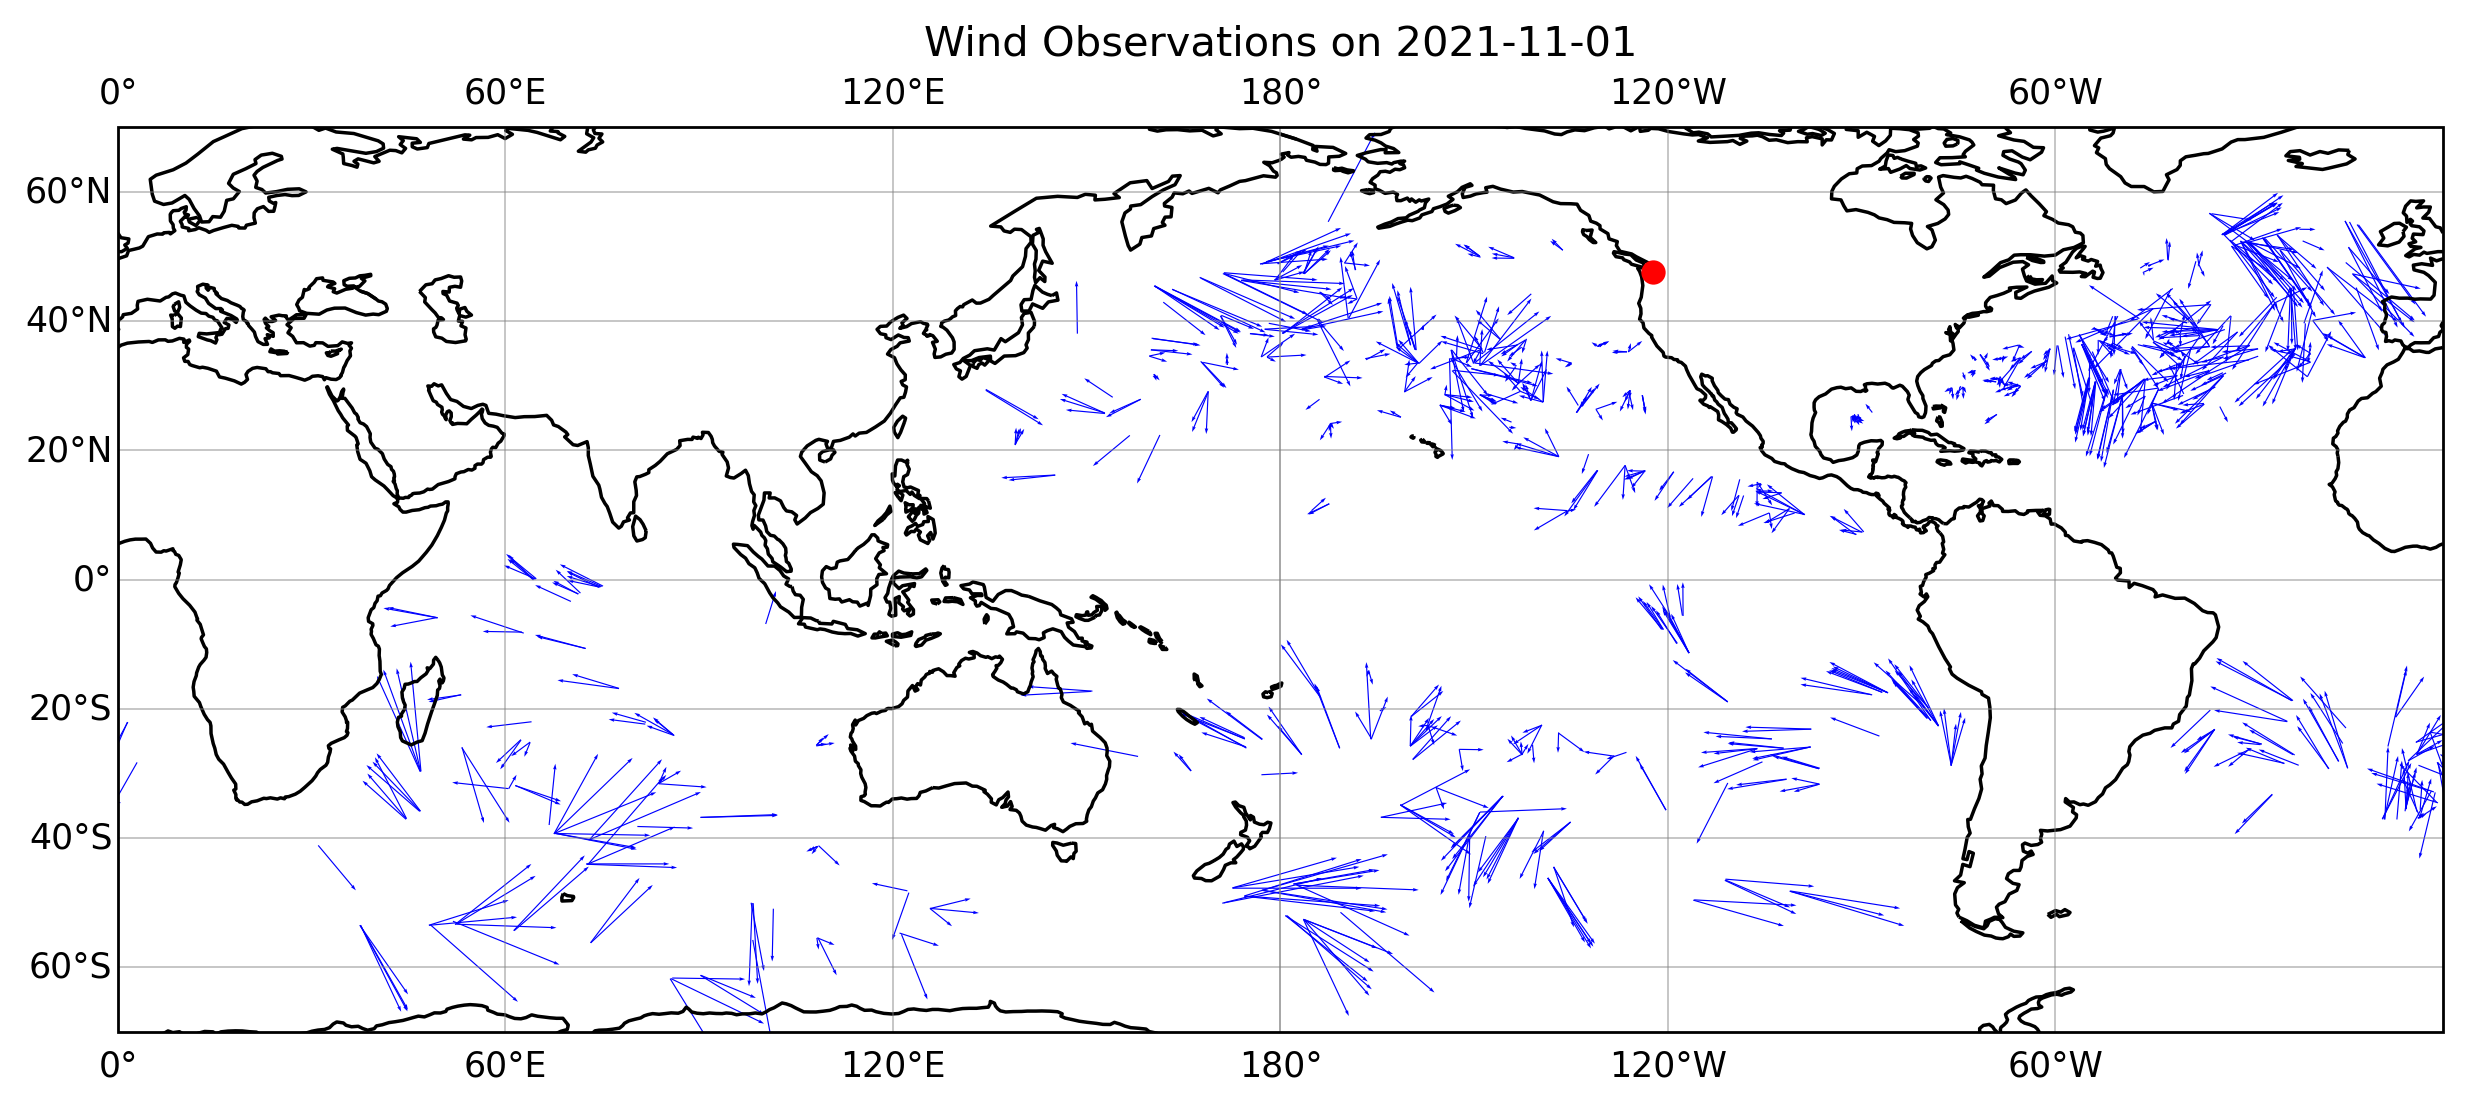

In [49]:
# set plotting parameters (min, max for colors and map projection)
h_min = 1
h_max = 6

proj = ccrs.PlateCarree(central_longitude=180)

time = '2021-11-01'

# set up cartopy map
fig, ax = plt.subplots(1,1, figsize=[12,7], subplot_kw={'projection': proj}, dpi=250)
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=.5, color='grey', alpha=0.5)

ax.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())

N = 10
windlat = testing.sel(time=time).lat.data
windlon = testing.sel(time=time).lon.data
u = testing.sel(time=time).u10_era5.data
v = testing.sel(time=time).v10_era5.data

Lat_Seattle=47.6062; Lon_Seattle=-122.3321  # Seattle coordinate

plt.plot(Lon_Seattle,Lat_Seattle,      # add a red dot for Seattle location!
         marker='o',color='red',
         transform=ccrs.PlateCarree())

ax.quiver(windlon[::N], windlat[::N], u[::N], v[::N],
          transform=ccrs.PlateCarree(),
          width=0.0005, 
          scale=300,
          color='blue')

#cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(f'Wind Observations on 2021-11-01')
plt.show()

In [227]:
testing.sel(time='2021-11-01')["u10_era5"].groupby('time.day').mean()

<xarray.DataArray 'u10_era5' (day: 1)> Size: 8B
array([2.17419167])
Coordinates:
  * day      (day) int64 8B 1

In [80]:
# THIS IS HOW YOU SPLIT UP THE DATA BY CONSISTENT INTERVAL

N = 10
testing.sel(time='2021-11-01').lat.data[::N]

array([-29.27988, -26.02023, -28.40597, ...,  49.57848, -37.18575,
        39.62885])

# Plotting sig wave height by day

In [112]:
lineplot_spotter_data='spotter_data_bulk.nc'    #loading from local path

lineplot_spotter = xr.open_dataset(lineplot_spotter_data)  #xarray can open different format data, netcdf is one of them

#lineplot_spotter = lineplot_spotter.drop_vars(["peakPeriod", "meanPeriod", "peakDirection", "peakDirectionalSpread", "meanDirection", "meanDirectionalSpread", "rowsize"])

#spotter = spotter.drop_dims("index")

lineplot_spotter = lineplot_spotter.sortby('time')
lineplot_spotter = lineplot_spotter.isel(index=slice(4885158, 5536373))
lineplot_spotter

# Select data for a specific buoy by its 'trajectory' value
buoy_id = 'SPOT-0907'  # Replace with the actual ID of the buoy you're interested in
buoy_data = lineplot_spotter.sel(trajectory=buoy_id)
# Now buoy_data contains only the data for the specified buoy <--- i think this is for choosing which buoy



In [120]:
lineplot_spotter

<xarray.Dataset> Size: 52MB
Dimensions:                (index: 651215, trajectory: 871)
Coordinates:
    time                   (index) datetime64[ns] 5MB ...
  * trajectory             (trajectory) <U12 42kB 'SPOT-010001' ... 'SPOT-1975'
Dimensions without coordinates: index
Data variables:
    significantWaveHeight  (index) float64 5MB ...
    peakPeriod             (index) float64 5MB ...
    meanPeriod             (index) float64 5MB ...
    peakDirection          (index) float64 5MB ...
    peakDirectionalSpread  (index) float64 5MB ...
    meanDirection          (index) float64 5MB ...
    meanDirectionalSpread  (index) float64 5MB ...
    latitude               (index) float64 5MB ...
    longitude              (index) float64 5MB ...
    rowsize                (trajectory) int64 7kB 2431 3679 2961 ... 3506 4218
Attributes:
    title:          Sofar Spotter Data Archive - Bulk Wave Parameters
    institution:    Sofar Ocean
    source:         Spotter wave buoy
    creation_date:  2023-10-18 00:43:55.333537
    author:         Isabel A. Houghton
    email:          isabel.houghton@sofarocean.com
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...

In [119]:
# choose a drifter by ID
spotter_id = 'SPOT-0164'

traj_idx = np.insert(np.cumsum(lineplot_spotter.rowsize.values), 0, 0)
traj_idx

# find index of chosen drifter
j = np.where(lineplot_spotter.trajectory==spotter_id)[0][0]
print(f"Drifter index for {spotter_id} is {j}")


# create the slice index `sli` for data from that drifter
sli = slice(traj_idx[j], traj_idx[j+1])

filtered = lineplot_spotter.isel(index=sli)
filtered.latitude.data

Drifter index for SPOT-0164 is 248


array([ 45.39487,  50.12233, -33.2066 , ...,  29.67505, -34.14687,
       -15.87122])

In [ ]:
# choose a drifter by ID
spotter_id = 'SPOT-0907'
# get the size of the 'trajectory' dimension
traj_size = dss.dims['trajectory']
# create an array of cumulative indices for each trajectory
# Ensure traj_idx contains integers
traj_idx = np.insert(np.cumsum(np.ones(traj_size, dtype=int)), 0, 0)
# find index of chosen drifter
j = np.where(dss.trajectory==spotter_id)[0][0]
print(f"Drifter index for {spotter_id} is {j}""\n")
# create the slice index `sli` for data from that drifter
sli = slice(traj_idx[j], traj_idx[j+1])
filtered = dss.isel(trajectory=sli)
filtered


# Print the longitude and latitude for the selected buoy
longitude = filtered.longitude.values
latitude = filtered.latitude.values
print(f"Longitude for {spotter_id}: {longitude}")
print(f"Latitude for {spotter_id}: {latitude}")


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Define the time range of interest
init = '2021-12-01T00:00'
final = '2021-12-31T00:00'
target_time_start = np.datetime64(init)
target_time_end = np.datetime64(final)
# Find all data points within the time of interest in the dataset
all_indices = np.where((filtered.time > target_time_start) & (filtered.time < target_time_end))[0]
# Extract the relevant data
time_filtered = filtered.time[all_indices]
wave_height_filtered = filtered.significantWaveHeight[all_indices]
# Convert time to pandas datetime for easy grouping
time_filtered_pd = pd.to_datetime(time_filtered)
# Create a DataFrame for easy manipulation
df = pd.DataFrame({
    'time': time_filtered_pd,
    'wave_height': wave_height_filtered
})
# Calculate daily mean significant wave height
daily_mean_wave_height = df.groupby(df['time'].dt.date)['wave_height'].mean()
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(daily_mean_wave_height.index, daily_mean_wave_height.values, marker='o')
plt.xlabel('Day of December 2021')
plt.ylabel('Mean Significant Wave Height (m)')
plt.title('Daily Mean Significant Wave Height in December 2021 for Buoy SPOT-1975')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Finding number of buoys

In [159]:
spotter_data='spotter_data_bulk.nc'    #loading from local path

spotter = xr.open_dataset(spotter_data)  #xarray can open different format data, netcdf is one of them

spotter = spotter.drop_vars(["peakPeriod", "meanPeriod", "peakDirection", "peakDirectionalSpread", "meanDirection", "meanDirectionalSpread", "rowsize"])

#spotter = spotter.drop_dims("index")

spotter = spotter.sortby('time')
spotter = spotter.isel(index=slice(4885158, 5536373))
spotter

<xarray.Dataset> Size: 21MB
Dimensions:                (index: 651215, trajectory: 871)
Coordinates:
    time                   (index) datetime64[ns] 5MB ...
  * trajectory             (trajectory) <U12 42kB 'SPOT-010001' ... 'SPOT-1975'
Dimensions without coordinates: index
Data variables:
    significantWaveHeight  (index) float64 5MB ...
    latitude               (index) float64 5MB ...
    longitude              (index) float64 5MB ...
Attributes:
    title:          Sofar Spotter Data Archive - Bulk Wave Parameters
    institution:    Sofar Ocean
    source:         Spotter wave buoy
    creation_date:  2023-10-18 00:43:55.333537
    author:         Isabel A. Houghton
    email:          isabel.houghton@sofarocean.com
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...

In [172]:
mytime = np.datetime64('2021-11-01')
nexttime = mytime + np.timedelta64(1,'D')

k = np.where((spotter.time>=mytime) & (spotter.time<=nexttime))[0]
print(f"Drifter index is {k}")

spotter.isel(index=slice(0, 10429))

Drifter index is [    0     1     2 ... 10427 10428 10429]


<xarray.Dataset> Size: 376kB
Dimensions:                (index: 10429, trajectory: 871)
Coordinates:
    time                   (index) datetime64[ns] 83kB 2021-11-01T00:00:49 .....
  * trajectory             (trajectory) <U12 42kB 'SPOT-010001' ... 'SPOT-1975'
Dimensions without coordinates: index
Data variables:
    significantWaveHeight  (index) float64 83kB ...
    latitude               (index) float64 83kB ...
    longitude              (index) float64 83kB ...
Attributes:
    title:          Sofar Spotter Data Archive - Bulk Wave Parameters
    institution:    Sofar Ocean
    source:         Spotter wave buoy
    creation_date:  2023-10-18 00:43:55.333537
    author:         Isabel A. Houghton
    email:          isabel.houghton@sofarocean.com
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...